C:\Users\meetj\AppData\Local\Temp\ipykernel_30544\3138850220.py:114: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\meetj\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


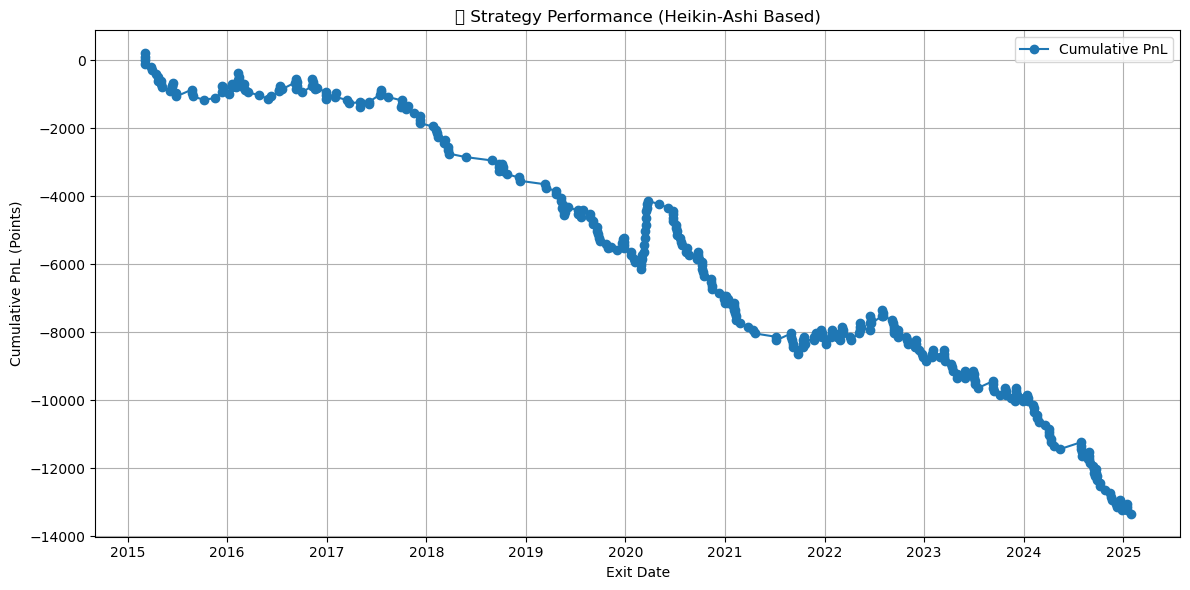

🔍 Total Trades: 366
✅ Wins: 85 | ❌ Losses: 281
🏆 Win Rate: 23.22%
💰 Total PnL: -13335.79 points


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta 

# === Load Data ===
df = pd.read_csv("NIFTY 50_daily_data.csv", parse_dates=['date'])
df.sort_values("date", inplace=True)  # ensure date order

# === Heikin-Ashi Calculation ===
ha_df = df.copy()
ha_df['HA_Close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4
ha_open = [(df['open'][0] + df['close'][0]) / 2]
for i in range(1, len(df)):
    ha_open.append((ha_open[i-1] + ha_df['HA_Close'][i-1]) / 2)
ha_df['HA_Open'] = ha_open
ha_df['HA_High'] = ha_df[['high', 'HA_Open', 'HA_Close']].max(axis=1)
ha_df['HA_Low'] = ha_df[['low', 'HA_Open', 'HA_Close']].min(axis=1)

# === Indicators using HA close ===
ha_df['rsi'] = ta.momentum.RSIIndicator(close=ha_df['HA_Close'], window=14).rsi()
adx_ind = ta.trend.ADXIndicator(high=ha_df['HA_High'], low=ha_df['HA_Low'], close=ha_df['HA_Close'], window=14)
ha_df['adx'] = adx_ind.adx()

macd = ta.trend.MACD(close=ha_df['HA_Close'], window_slow=26, window_fast=12, window_sign=9)
ha_df['macd_hist'] = macd.macd_diff()
ha_df['macd_diff'] = ha_df['macd_hist'].diff()

ha_df['sma9'] = ha_df['HA_Close'].rolling(window=9).mean()

# === Signal Logic ===
ha_df['buy_signal'] = (ha_df['rsi'] > 60) & (ha_df['adx'] > 19) & (ha_df['macd_diff'] > 5) & (ha_df['HA_Close'] > ha_df['sma9'])
ha_df['sell_signal'] = (ha_df['rsi'] < 40) & (ha_df['adx'] > 19) & (ha_df['macd_diff'] < -5) & (ha_df['HA_Close'] < ha_df['sma9'])

# === Trading Simulation ===
entry_buffer = 25
tp_points = 200
sl_points = 100
max_hold = 5

trades = []

for i in range(len(ha_df) - max_hold - 1):
    row = ha_df.iloc[i]
    if row['buy_signal'] or row['sell_signal']:
        entry_idx = i + 1
        if entry_idx + max_hold >= len(ha_df): continue

        entry_row = ha_df.iloc[entry_idx]
        entry_date = entry_row['date']
        entry_close = row['HA_Close']
        direction = 'BUY' if row['buy_signal'] else 'SELL'
        entry_price = entry_close + entry_buffer if direction == 'BUY' else entry_close - entry_buffer

        exit_price = None
        exit_date = None
        pnl = None

        for j in range(entry_idx, entry_idx + max_hold):
            high = ha_df.iloc[j]['HA_High']
            low = ha_df.iloc[j]['HA_Low']
            date = ha_df.iloc[j]['date']

            if direction == 'BUY':
                if high >= entry_price + tp_points:
                    exit_price = entry_price + tp_points
                    exit_date = date
                    pnl = tp_points
                    break
                elif low <= entry_price - sl_points:
                    exit_price = entry_price - sl_points
                    exit_date = date
                    pnl = -sl_points
                    break
            elif direction == 'SELL':
                if low <= entry_price - tp_points:
                    exit_price = entry_price - tp_points
                    exit_date = date
                    pnl = tp_points
                    break
                elif high >= entry_price + sl_points:
                    exit_price = entry_price + sl_points
                    exit_date = date
                    pnl = -sl_points
                    break

        if exit_price is None:
            exit_row = ha_df.iloc[entry_idx + max_hold]
            exit_price = exit_row['HA_Close']
            exit_date = exit_row['date']
            pnl = (exit_price - entry_price) if direction == 'BUY' else (entry_price - exit_price)

        trades.append({
            'Signal': direction,
            'Entry Date': entry_date,
            'Entry Price': round(entry_price, 2),
            'Exit Date': exit_date,
            'Exit Price': round(exit_price, 2),
            'PnL': round(pnl, 2)
        })

# === Results & Stats ===
trade_df = pd.DataFrame(trades)
trade_df['Cumulative PnL'] = trade_df['PnL'].cumsum()

# Plot PnL
plt.figure(figsize=(12, 6))
plt.plot(trade_df['Exit Date'], trade_df['Cumulative PnL'], marker='o', label="Cumulative PnL")
plt.title("📈 Strategy Performance (Heikin-Ashi Based)")
plt.xlabel("Exit Date")
plt.ylabel("Cumulative PnL (Points)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Stats
wins = (trade_df['PnL'] > 0).sum()
losses = (trade_df['PnL'] < 0).sum()
total = len(trade_df)
win_rate = 100 * wins / total if total > 0 else 0
total_pnl = trade_df['PnL'].sum()

print(f"🔍 Total Trades: {total}")
print(f"✅ Wins: {wins} | ❌ Losses: {losses}")
print(f"🏆 Win Rate: {win_rate:.2f}%")
print(f"💰 Total PnL: {total_pnl} points")

# Optional: Save
# trade_df.to_csv("heikin_ashi_strategy_result.csv", index=False)
